# Data Mining Course 2025 - Final Project
##  Submitted by:
Yuval Lebel

Adir Cohen

This project, including data processing pipelines, classification models, and unsupervised analysis, was developed and optimized with the assistance of Google Gemini AI

In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


In [2]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Data_ML

Mounted at /content/drive
/content/drive/MyDrive/Data_ML


###  טעינה ואיחוד ראשוני של הנתונים -data gov+TEA

In [3]:
# # 2. פונקציה לניקוי מזהה בית הספר (הסרת גרשים והמרה למספר)
# def clean_id(df, col):
#     df[col] = df[col].astype(str).str.replace("'", "").str.strip()
#     return pd.to_numeric(df[col], errors='coerce')

# try:
#     # נסיון קריאה עם קידוד Windows-1255 (נפוץ מאוד לקבצי אקסל בעברית)
#     df_school = pd.read_csv('School_data.csv', encoding='cp1255')
# except UnicodeDecodeError:
#     # אם נכשל, ננסה קידוד ISO-8859-8 (פורמט עברי נוסף)
#     df_school = pd.read_csv('School_data.csv', encoding='iso-8859-8')
# except Exception as e:
#     print(f"שגיאה בטעינת School_data: {e}")

# # שאר הקבצים הם באנגלית ולכן utf-8 רגיל אמור לעבוד,
# # אבל הוספנו latin1 כגיבוי למקרה שיש שם תווים מיוחדים
# df_ref = pd.read_csv('CREF.csv', encoding='latin1', low_memory=False)
# df_staff = pd.read_csv('CSTAF.csv', encoding='latin1', low_memory=False)
# df_student = pd.read_csv('CSTUD.csv', encoding='latin1', low_memory=False)

# # 4. הכנת המפתחות לאיחוד
# df_school['CAMPUS'] = clean_id(df_school, 'Campus\nNumber')
# df_ref['CAMPUS'] = clean_id(df_ref, 'CAMPUS')
# df_staff['CAMPUS'] = clean_id(df_staff, 'CAMPUS')
# df_student['CAMPUS'] = clean_id(df_student, 'CAMPUS')

# # הסרת שורות ריקות של מחוזות (כדי שיישארו רק בתי ספר)
# df_school = df_school.dropna(subset=['CAMPUS'])

# # 5. איחוד (Merge)
# print("מבצע איחוד...")
# # איחוד נתוני הרקע (מורים ותלמידים)
# df_tapr = pd.merge(df_ref, df_staff, on='CAMPUS', how='inner', suffixes=('', '_staff'))
# df_tapr = pd.merge(df_tapr, df_student, on='CAMPUS', how='inner', suffixes=('', '_student'))

# # חיבור לדירוג המטרה
# df_final = pd.merge(df_school, df_tapr, on='CAMPUS', how='left')

# # 6. שמירת קובץ עבודה נקי
# df_final.to_csv('Master_Dataset.csv', index=False)
# print(f"✅ סיום! נוצר קובץ Master_Dataset.csv עם {df_final.shape[1]} עמודות.")

In [4]:
# טעינת קובץ המאסטר שיצרנו
df = pd.read_csv('Master_Dataset.csv')
# 2. סינון בתי ספר ללא דירוג רשמי (A-F)
# חלק מבתי הספר מקבלים "Not Rated" בגלל גודלם או נסיבות מיוחדות
df = df[df['Overall\nRating'].isin(['A', 'B', 'C', 'D', 'F'])].copy()

# 3. המרת הדירוג למספרים (Target)
rating_map = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}
df['target'] = df['Overall\nRating'].map(rating_map)

print(f"מספר רשומות לניתוח: {len(df)}")
print(f"מספר עמודות כולל: {df.shape[1]}")

מספר רשומות לניתוח: 8539
מספר עמודות כולל: 389


בחרנו מהדאטה את העמדות שנראו לנו המועילות ביותר

In [5]:
# רשימת הפיצ'רים הסופית והעשירה ביותר (Students + Staff + Context)
final_feature_list = [
    'CAMPUS', 'Overall\nRating', 'School\nType', 'CFLCHART', 'CFLALTED',
    'Number of\nStudents','target', 'CPEMECOP', 'CPETLEPP', 'CPETRSKP', 'CPETSPEC',
    'CPETWHIP', 'CPETHISP', 'CPETBLAP', 'CPETASIP', 'CPETATTP',
    'CPETGIFP', 'CPET504P', 'CPETDSLP', 'CPETHOMP', 'CPETIMMP', 'CPETBILP',
    'CPETMALP', 'CPETFEMP', 'CPETMIGP',
    'CPSTTOSA', 'CPSTEXPA', 'CPSTTENA', 'CPSTKIDR', 'CPSTMAFC', 'CPSTPHFC', 'REGION'

]

# סינון הדאטה המאוחד
df_ml = df[final_feature_list].copy()

# 1. ניקוי משתנה המטרה (חובה!)
df_ml = df_ml[df_ml['Overall\nRating'].isin(['A', 'B', 'C', 'D', 'F'])]

# 2. המרת ערכים בינאריים ל-0 ו-1
for col in ['CFLCHART', 'CFLALTED']:
    df_ml[col] = df_ml[col].map({'N': 0, 'Y': 1})

# 3. טיפול בערכים חסרים (Imputation)
# בנתוני תלמידים, אם ערך חסר, לרוב זה אומר 0% (למשל 0 מהגרים)
student_p_cols = [c for c in df_ml.columns if c.startswith('CPET')]
df_ml[student_p_cols] = df_ml[student_p_cols].fillna(0)

# 4. המרת המטרה למספרים
target_map = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}
df_ml['target'] = df_ml['Overall\nRating'].map(target_map)

print(f"הדאטה המורחב מוכן! {df_ml.shape[1]} עמודות.")
df_ml.head()

הדאטה המורחב מוכן! 32 עמודות.


,CAMPUS,Overall\nRating,School\nType,CFLCHART,CFLALTED,Number of\nStudents,target,CPEMECOP,CPETLEPP,CPETRSKP,...,CPETMALP,CPETFEMP,CPETMIGP,CPSTTOSA,CPSTEXPA,CPSTTENA,CPSTKIDR,CPSTMAFC,CPSTPHFC,REGION
0,1902001.0,A,High School,0,0,171,4,10,1.8,36.8,...,53.8,46.2,0.0,57104,13,5.6,8.8,8.3,0,'07
1,1902041.0,B,Middle School,0,0,166,3,20,0.6,32.5,...,56.6,43.4,0.0,58061,14.9,7.7,14.8,1.5,0,'07
2,1902103.0,C,Elementary,0,0,256,2,21.4,1.6,46.9,...,48.4,51.6,0.0,54371,16.3,11.9,14.3,0.9,0,'07
3,1903001.0,A,High School,0,0,315,4,18,1.3,29.5,...,52.4,47.6,0.0,48403,13.3,7,8.8,16.9,1,'07
4,1903041.0,B,Middle School,0,0,270,3,18.2,1.9,37.8,...,51.1,48.9,0.0,45761,11.2,4.9,11.3,3.2,0,'07


In [6]:
def to_numeric_clean(df, col):
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace('%', '').str.replace(',', '')
        # הפיכת נקודות בודדות ל-NaN
        df[col] = df[col].replace('.', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    return df[col]

# רשימת העמודות הנומריות שצריך להמיר
cols_to_fix = [
    'Number of\nStudents', 'CPEMECOP', 'CPETLEPP', 'CPETRSKP', 'CPETSPEC',
    'CPETWHIP', 'CPETHISP', 'CPETBLAP', 'CPETASIP', 'CPETATTP',
    'CPETGIFP', 'CPET504P', 'CPETDSLP', 'CPETHOMP', 'CPETIMMP', 'CPETBILP',
    'CPETMALP', 'CPETFEMP', 'CPETMIGP',
    'CPSTTOSA', 'CPSTEXPA', 'CPSTTENA', 'CPSTKIDR', 'CPSTMAFC', 'CPSTPHFC'
]

for col in cols_to_fix:
    if col in df_ml.columns:
        df_ml[col] = to_numeric_clean(df_ml, col)

print(" כל העמודות הומרו למספרים בהצלחה.")

 כל העמודות הומרו למספרים בהצלחה.


In [7]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8539 entries, 0 to 9043
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CAMPUS              8539 non-null   float64
 1   Overall
Rating      8539 non-null   object 
 2   School
Type         8539 non-null   object 
 3   CFLCHART            8539 non-null   int64  
 4   CFLALTED            8539 non-null   int64  
 5   Number of
Students  8539 non-null   int64  
 6   target              8539 non-null   int64  
 7   CPEMECOP            8196 non-null   float64
 8   CPETLEPP            8539 non-null   float64
 9   CPETRSKP            8539 non-null   float64
 10  CPETSPEC            8539 non-null   int64  
 11  CPETWHIP            8539 non-null   float64
 12  CPETHISP            8539 non-null   float64
 13  CPETBLAP            8539 non-null   float64
 14  CPETASIP            8539 non-null   float64
 15  CPETATTP            8505 non-null   float64
 16  CPETGIFP   

In [8]:
print(f"שורות: {df_ml.shape[0]}, עמודות: {df_ml.shape[1]}")
print("\nסוגי משתנים:")
print(df_ml.dtypes.value_counts())

שורות: 8539, עמודות: 32

סוגי משתנים:
float64    24
int64       5
object      3
Name: count, dtype: int64


# **Supervised learning**

## ניתוח ערכים חסרים

In [9]:
# חוסרים
missing = df_ml.isnull().sum()
missing_pct = (missing / len(df_ml)) * 100
print("עמודות עם הכי הרבה חוסרים (%):")
print(missing_pct[missing_pct > 0].sort_values(ascending=False).head(10))

# כפילויות
duplicates = df_ml.duplicated().sum()
print(f"\nמספר שורות כפולות: {duplicates}")

עמודות עם הכי הרבה חוסרים (%):
CPEMECOP    4.016864
CPSTTOSA    0.585549
CPSTEXPA    0.421595
CPSTTENA    0.421595
CPSTMAFC    0.421595
CPSTKIDR    0.421595
CPSTPHFC    0.421595
CPETATTP    0.398173
dtype: float64

מספר שורות כפולות: 0


## התפלגות משתנה המטרה

/tmp/ipython-input-1532172790.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Overall\nRating', data=df_ml, order=['A', 'B', 'C', 'D', 'F'], palette='viridis')


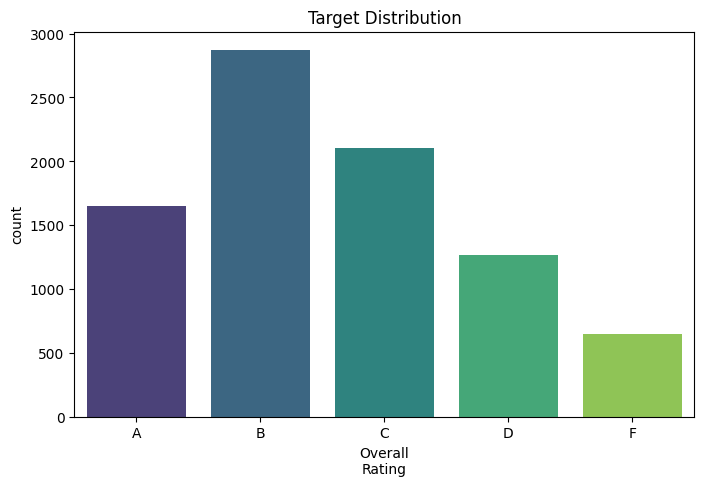

Overall\nRating
B    33.645626
C    24.675020
A    19.276262
D    14.802670
F     7.600422
Name: proportion, dtype: float64


In [10]:


plt.figure(figsize=(8, 5))
sns.countplot(x='Overall\nRating', data=df_ml, order=['A', 'B', 'C', 'D', 'F'], palette='viridis')
plt.title('Target Distribution')
plt.show()

# אחוזים מדויקים
print(df_ml['Overall\nRating'].value_counts(normalize=True) * 100)

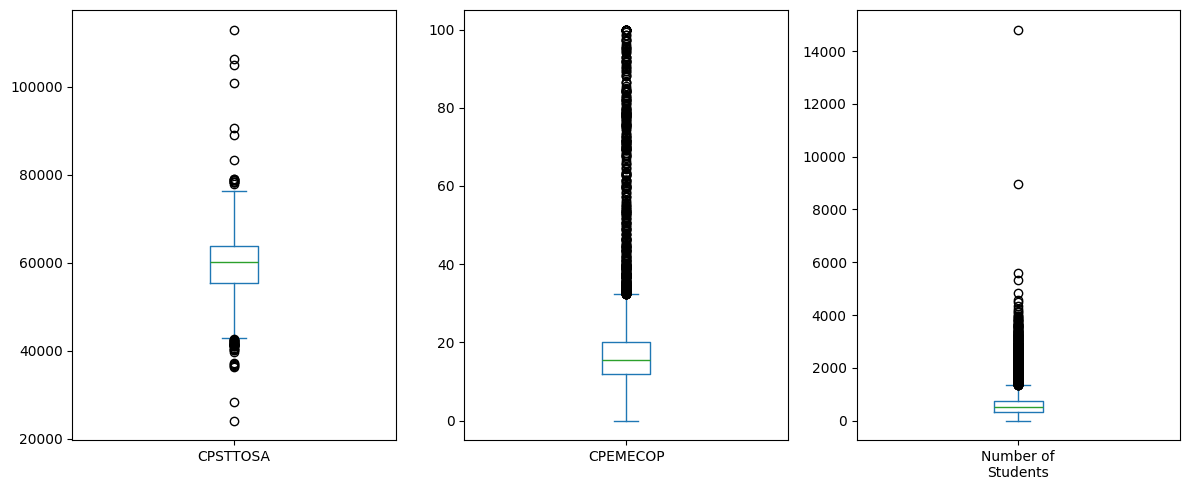

In [11]:
# בדיקת חריגים למשתנים נומריים נבחרים
cols_to_check = ['CPSTTOSA', 'CPEMECOP', 'Number of\nStudents']
df_ml[cols_to_check].plot(kind='box', subplots=True, layout=(1,3), figsize=(12,5))
plt.tight_layout()
plt.show()

אנו רואים שיש בפיצ'רים הנ"ל ערכים חריגים. נסיר אותם כדי שלא יפגעו לנו במודל.


In [12]:
# נשמור את מספר השורות המקורי כדי לראות כמה הסרנו
initial_rows = df_ml.shape[0]
# רשימת העמודות לניקוי (אלו שראינו בהן חריגים בגרף)
cols_to_clean = ['CPSTTOSA', 'CPEMECOP', 'Number of\nStudents']

for col in cols_to_clean:
    Q1 = df_ml[col].quantile(0.25)
    Q3 = df_ml[col].quantile(0.75)
    IQR = Q3 - Q1

    # הגדרת הגבולות
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # סינון הנתונים - השארת רק מה שבטווח
    df_ml = df_ml[(df_ml[col] >= lower_bound) & (df_ml[col] <= upper_bound)]

removed_rows = initial_rows - df_ml.shape[0]
print(f"✅ תהליך הניקוי הסתיים.")
print(f"הוסרו {removed_rows} בתי ספר שנחשבו לחריגים קיצוניים.")
print(f"מספר שורות סופי לעבודה: {df_ml.shape[0]}")

✅ תהליך הניקוי הסתיים.
הוסרו 1379 בתי ספר שנחשבו לחריגים קיצוניים.
מספר שורות סופי לעבודה: 7160


## בדיקת קורולציות בין המשתנים

In [13]:


X = df_ml.drop(columns=['CAMPUS', 'Overall\nRating', 'target'])
y = df_ml['target']
# 2. הגדרת סוגי העמודות
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


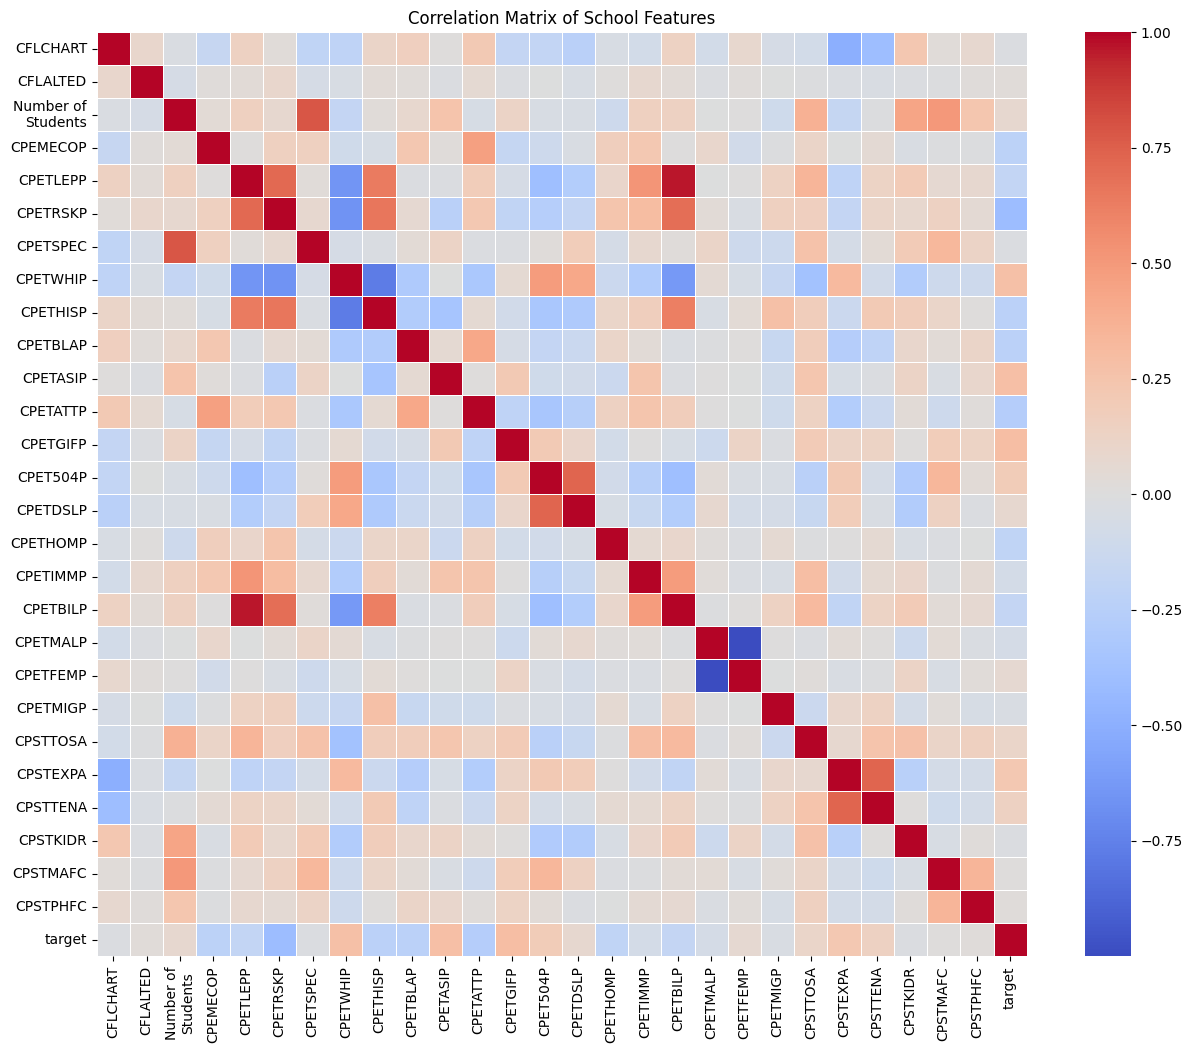


--- הקורלציה של כל משתנה עם הדירוג הסופי (Target) ---
target                 1.000000
CPETGIFP               0.289344
CPETASIP               0.286170
CPETWHIP               0.280567
CPSTEXPA               0.219277
CPET504P               0.187536
CPSTTENA               0.142067
CPSTTOSA               0.103062
CPETDSLP               0.076378
Number of\nStudents    0.074465
CPETFEMP               0.067921
CFLALTED               0.025515
CPSTPHFC               0.019823
CPSTMAFC               0.011418
CPETSPEC              -0.018249
CFLCHART              -0.018765
CPSTKIDR              -0.020471
CPETMIGP              -0.035599
CPETMALP              -0.067950
CPETIMMP              -0.072275
CPETBILP              -0.177261
CPETLEPP              -0.186034
CPETHOMP              -0.202947
CPEMECOP              -0.221065
CPETHISP              -0.227190
CPETBLAP              -0.229459
CPETATTP              -0.268656
CPETRSKP              -0.409787
Name: target, dtype: float64


In [14]:
# 1. חישוב מטריצת הקורלציות רק למשתנים הנומריים
# אנחנו כוללים את ה-target כדי לראות מה משפיע עליו
corr_matrix = df_ml[numeric_features + ['target']].corr()

# 2. יצירת מפת חום (Heatmap)
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of School Features')
plt.show()

# 3. הצגת הקורלציה הספציפית למשתנה המטרה (בצורה מסודרת)
print("\n--- הקורלציה של כל משתנה עם הדירוג הסופי (Target) ---")
target_corr = corr_matrix['target'].sort_values(ascending=False)
print(target_corr)

In [15]:
import numpy as np

# 1. הגדרת סף הקורלציה (Threshold)
threshold = 0.8

# 2. חישוב מטריצת קורלציה רק למשתנים הבלתי-תלויים (בלי ה-target)
features_corr = df_ml[numeric_features].corr().abs()

# 3. יצירת "מסכה" כדי לא לבדוק כל זוג פעמיים (למשל א-ב וב-א) ולא לבדוק משתנה מול עצמו
upper = features_corr.where(np.triu(np.ones(features_corr.shape), k=1).astype(bool))

# 4. מציאת זוגות עם קורלציה מעל הסף
high_corr_pairs = [(column, row) for row in upper.index for column in upper.columns if upper.loc[row, column] > threshold]

if not high_corr_pairs:
    print(f"✅ לא נמצאו זוגות עם קורלציה גבוהה מ-{threshold}. המשתנים עצמאיים מספיק!")
else:
    print(f" נמצאו {len(high_corr_pairs)} זוגות עם קורלציה גבוהה מ-{threshold}:")
    for pair in high_corr_pairs:
        val = features_corr.loc[pair[0], pair[1]]
        print(f"- {pair[0]} ו-{pair[1]}: {val:.2f}")

# 5. זיהוי עמודות פוטנציאליות להסרה (אלו שחוזרות על עצמן)
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(f"\nהמלצה: כדאי לשקול להסיר את {len(to_drop)} העמודות הבאות כדי למנוע כפילות: {to_drop}")

 נמצאו 2 זוגות עם קורלציה גבוהה מ-0.8:
- CPETBILP ו-CPETLEPP: 0.96
- CPETFEMP ו-CPETMALP: 1.00

המלצה: כדאי לשקול להסיר את 2 העמודות הבאות כדי למנוע כפילות: ['CPETBILP', 'CPETFEMP']


נסיר עמודות עם קורולציה גבוהה

In [16]:
cols_to_drop = ['CPETBILP', 'CPETFEMP']
df_ml = df_ml.drop(columns=cols_to_drop)

# עדכון רשימת המשתנים הנומריים כדי שלא יחפש את מה שמחקנו בהמשך
numeric_features = [f for f in numeric_features if f not in cols_to_drop]

print(f" העמודות {cols_to_drop} הוסרו בהצלחה.")
print(f"מספר המשתנים הנומריים שנותרו: {len(numeric_features)}")


 העמודות ['CPETBILP', 'CPETFEMP'] הוסרו בהצלחה.
מספר המשתנים הנומריים שנותרו: 25


## Feature Engineering

In [17]:


# 1. יחס שכר לניסיון (כמה משלמים על שנת ניסיון)
df_ml['Teacher_Salary_Efficiency'] = df_ml['CPSTTOSA'] / (df_ml['CPSTEXPA'] + 1)

# 2. מדד שימור - ותק במחוז לעומת ותק כללי
df_ml['Teacher_Retention_Index'] = df_ml['CPSTTENA'] / (df_ml['CPSTEXPA'] + 1)

# 3. אינטראקציה בין עוני לסיכון (Social Vulnerability)
df_ml['Social_Vulnerability_Index'] = (df_ml['CPEMECOP'] / 100) * (df_ml['CPETRSKP'] / 100)

# 4. עומס תמיכה (חינוך מיוחד + ELL)
df_ml['Support_Intensity'] = df_ml['CPETSPEC'] + df_ml['CPETLEPP']

# עדכון רשימת המשתנים הנומריים
new_features = ['Teacher_Salary_Efficiency', 'Teacher_Retention_Index',
                'Social_Vulnerability_Index', 'Support_Intensity']
numeric_features = numeric_features + new_features


print(f"✅ נוספו {len(new_features)} משתנים חדשים למודל.")

✅ נוספו 4 משתנים חדשים למודל.


## Pipline+Models

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# 1. הכנת רשימות המשתנים מתוך df_ml
# זיהוי אוטומטי של כל העמודות הנומריות (כולל אלו שהוספת בפיצ'ר אנג'ינירינג)
current_numeric = df_ml.select_dtypes(include=['int64', 'float64']).columns.tolist()

# הסרת עמודות המטרה והמזהה מהרשימה של המשתנים המנבאים
for col in ['target', 'CAMPUS']:
    if col in current_numeric:
        current_numeric.remove(col)

# משתנים קטגוריאליים (נשארים כפי שהיו)
categorical_features = ['School\nType', 'REGION']

# 2. בניית ה-Preprocessor
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_final = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, current_numeric),
        ('cat', categorical_transformer, categorical_features)
    ])

# 3. הפרדת נתונים ל-X ו-y מתוך df_ml
X = df_ml.drop(columns=['CAMPUS', 'Overall\nRating', 'target'])
y = df_ml['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. הגדרת המודלים (XGBoost בפנים, Decision Tree בחוץ)
models_to_tune = [
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('Random Forest', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('SVM', SVC(class_weight='balanced')),
    ('KNN', KNeighborsClassifier())
]

# 5. הגדרת רשת הפרמטרים (Param Grid)
param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5]
    },
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['rbf']
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 11],
        'classifier__weights': ['uniform', 'distance']
    }
}

# 6. הרצת ה-Grid Search
grid_results = []
print("🚀 מתחיל Grid Search מבוסס F1-Weighted על df_ml...")

for name, model in models_to_tune:
    print(f"🔍 בודק מודל: {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_final), ('classifier', model)])

    # חיפוש אופטימלי לפי f1_weighted
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    grid_results.append({
        'Model': name,
        'Best F1 Score': grid_search.best_score_,
        'Best Params': grid_search.best_params_
    })

# 7. הצגת טבלה מסכמת
final_comparison_df = pd.DataFrame(grid_results).sort_values(by='Best F1 Score', ascending=False)
print("\n--- סיכום תוצאות סופי ---")
pd.set_option('display.max_colwidth', None)
print(final_comparison_df)

🚀 מתחיל Grid Search מבוסס F1-Weighted על df_ml...
🔍 בודק מודל: XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:42:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔍 בודק מודל: Random Forest...
🔍 בודק מודל: Logistic Regression...
🔍 בודק מודל: SVM...
🔍 בודק מודל: KNN...

--- סיכום תוצאות סופי ---
                 Model  Best F1 Score  \
1        Random Forest       0.449881   
0              XGBoost       0.446183   
3                  SVM       0.425321   
4                  KNN       0.418585   
2  Logistic Regression       0.416078   

                                                                                          Best Params  
1  {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}  
0     {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}  
3                     {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}  
4                                   {'classifier__n_neighbors': 11, 'classifier__weights': 'uniform'}  
2                                             {'classifier__C': 1, 'classifier__solver': 'liblinear'

### סיכום תוצאות המודלים:

המודל שהשיג את ציון ה-F1 Weighted הטוב ביותר היה **Random Forest** עם ציון של **0.449**.

הפרמטרים האופטימליים עבור מודל זה היו:
* `n_estimators`: 100
* `max_depth`: 20
* `min_samples_split`: 5

כעת נבדוק פיצ'ר אימפורטנס ונסיר משתנים לא חשובים.

✅ תהליך הזיקוק הסתיים.
מתוך 53 משתנים מקוריים, השארנו רק 26 משתנים קריטיים.
המשתנים שנבחרו: ['Number of\nStudents', 'CPEMECOP', 'CPETLEPP', 'CPETRSKP', 'CPETSPEC', 'CPETWHIP', 'CPETHISP', 'CPETBLAP', 'CPETASIP', 'CPETATTP', 'CPETGIFP', 'CPET504P', 'CPETDSLP', 'CPETHOMP', 'CPETIMMP', 'CPETMALP', 'CPETMIGP', 'CPSTTOSA', 'CPSTEXPA', 'CPSTTENA', 'CPSTKIDR', 'CPSTMAFC', 'Teacher_Salary_Efficiency', 'Teacher_Retention_Index', 'Social_Vulnerability_Index', 'Support_Intensity']


/tmp/ipython-input-3044782138.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(len(selected_features_names)), palette='magma')


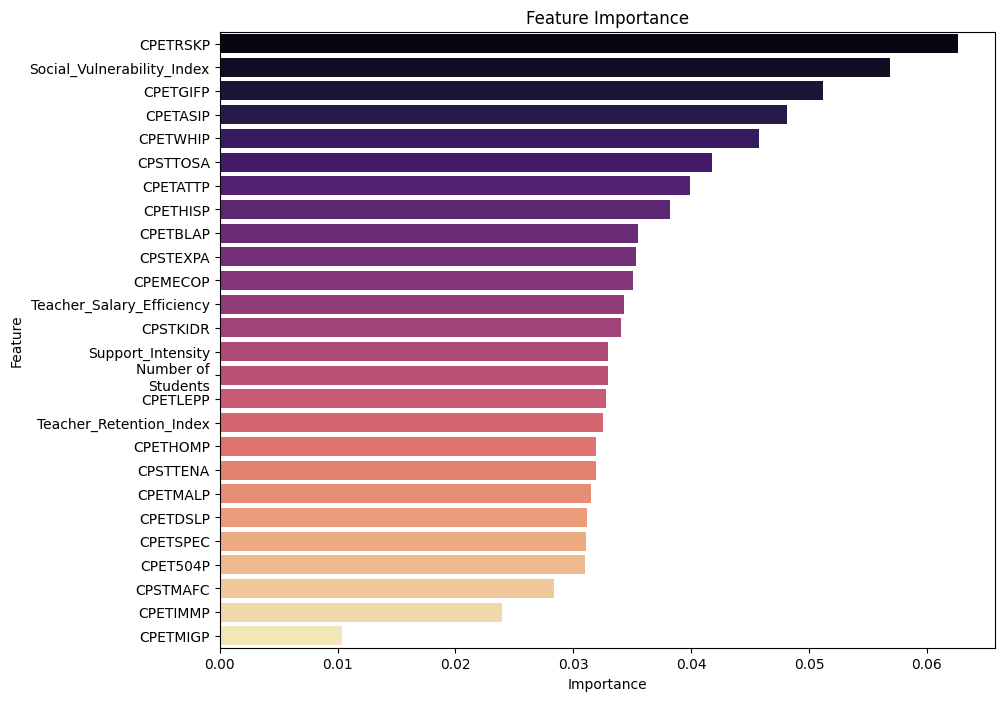

In [19]:
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

# 1. הגדרת המודל המנצח עם הפרמטרים מה-Grid Search
best_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)

# 2. יצירת פייפליין לזיהוי חשיבות (משתמשים ב-X_train המלא כדי לראות הכל)
selector_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_final),
    ('classifier', best_clf)
])

selector_pipeline.fit(X_train, y_train)

# 3. חילוץ שמות המשתנים וחשיבותם
ohe_cols = list(selector_pipeline.named_steps['preprocessor'].transformers_[1][1]\
                .named_steps['onehot'].get_feature_names_out(categorical_features))
all_features = numeric_features + ohe_cols
importances = selector_pipeline.named_steps['classifier'].feature_importances_

# יצירת טבלה מסודרת
feature_imp_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})\
                   .sort_values(by='Importance', ascending=False)

# 4. בחירת משתנים (Feature Selection)
# נגדיר סף: כל משתנה שתורם פחות מהממוצע או סף שנקבע (למשל 0.01)
selector = SelectFromModel(best_clf, threshold=0.01, prefit=False)

# כדי להריץ את הסלקטור, אנחנו צריכים את הנתונים אחרי ה-Preprocessor
X_train_preprocessed = selector_pipeline.named_steps['preprocessor'].transform(X_train)
selector.fit(X_train_preprocessed, y_train)

# קבלת המשתנים שנבחרו
selected_features_mask = selector.get_support()
selected_features_names = [f for f, s in zip(all_features, selected_features_mask) if s]

print(f"✅ תהליך הזיקוק הסתיים.")
print(f"מתוך {len(all_features)} משתנים מקוריים, השארנו רק {len(selected_features_names)} משתנים קריטיים.")
print(f"המשתנים שנבחרו: {selected_features_names}")

# 5. הצגת גרף חשיבות המשתנים הסופיים

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(len(selected_features_names)), palette='magma')
plt.title('Feature Importance')
plt.show()

--- דו"ח ביצועים מודל סופי (26 משתנים) ---
              precision    recall  f1-score   support

           F       0.46      0.31      0.37       109
           D       0.35      0.29      0.32       214
           C       0.34      0.32      0.33       357
           B       0.45      0.62      0.52       481
           A       0.69      0.49      0.57       271

    accuracy                           0.45      1432
   macro avg       0.46      0.40      0.42      1432
weighted avg       0.45      0.45      0.44      1432

--- מדד מרחק הטעות ---
Mean Absolute Error (MAE): 0.71 דרגות


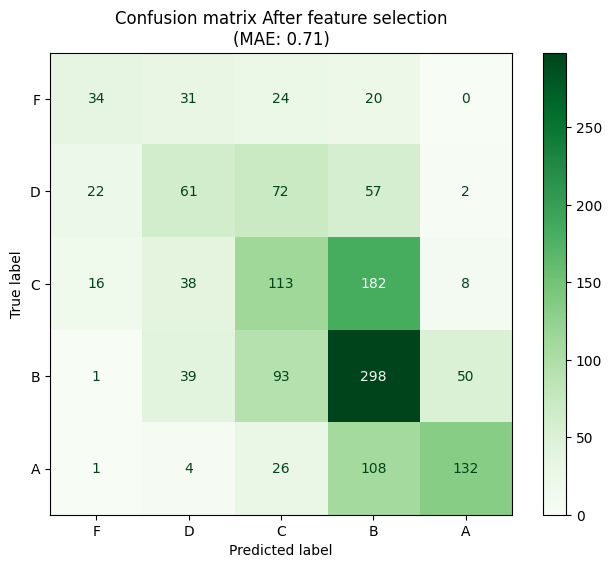

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error
import matplotlib.pyplot as plt

# 1. סינון הנתונים - השארת המשתנים החשובים בלבד
final_features = [f for f in X.columns if f in selected_features_names or any(f in sf for sf in selected_features_names)]

X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

# 2. עדכון ה-Preprocessor
final_numeric_features = [f for f in numeric_features if f in final_features]
final_categorical_features = [f for f in categorical_features if f in final_features]

final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, final_numeric_features),
        ('cat', categorical_transformer, final_categorical_features)
    ])

# 3. המודל הסופי (מבוסס המשתנים שנבחרו)
final_model_pipeline = Pipeline(steps=[
    ('preprocessor', final_preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42))
])

# 4. אימון והערכה
final_model_pipeline.fit(X_train_final, y_train)
y_pred_final = final_model_pipeline.predict(X_test_final)

# 5. חישוב MAE (מדד המרחק הממוצע של הטעות)
final_mae = mean_absolute_error(y_test, y_pred_final)

# 6. הצגת התוצאות
print(f'--- דו"ח ביצועים מודל סופי ({len(final_features)} משתנים) ---')
print(classification_report(y_test, y_pred_final, target_names=['F', 'D', 'C', 'B', 'A']))

print(f"--- מדד מרחק הטעות ---")
print(f"Mean Absolute Error (MAE): {final_mae:.2f} דרגות")

# מטריצת בלבול
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['F', 'D', 'C', 'B', 'A'])
disp.plot(cmap='Greens', values_format='d', ax=ax)
plt.title(f'Confusion matrix After feature selection\n(MAE: {final_mae:.2f})')
plt.show()

במבט ראשון, מדד ה-F1 Score שקיבלנו (סביב 0.45) עשוי להיראות נמוך. עם זאת, חשוב להבין את מהות הבעיה שאנו פותרים: דירוג בתי ספר (A-F) הוא משתנה סדרתי (Ordinal) ולא קטגוריאלי רגיל.

מדד ה-F1 מחמיר מאוד – הוא מתייחס לטעות של דרגה אחת (למשל, חיזוי B במקום A) כאל כישלון מוחלט, בדיוק כמו טעות של ארבע דרגות (חיזוי F במקום A). לעומת זאת, מדד ה-MAE (Mean Absolute Error) שקיבלנו מראה תמונה אופטימית בהרבה. ה-MAE מודד כמה המודל 'רחוק' מהדירוג האמיתי.

העובדה שה-MAE נמוך מעידה על כך שגם כשהמודל טועה, הוא בדרך כלל טועה 'קרוב' – כלומר, הוא חוזה רמה אחת מעל או מתחת לדירוג האמיתי. מבחינה עסקית וחינוכית, למודל שקולע לדרגה הסמוכה יש ערך רב, שכן הוא מצליח לזהות את ה'מגמה' של בית הספר (חזק, בינוני או חלש) גם אם לא פגע בדיוק בציון המדויק. לכן, אנו מגדירים את ביצועי המודל כטובים ושימושיים עבור המערכת."

# **Unsupervised learning**

# Clustering

בשלב זה נבצע חלוקה של בתי הספר לאשכולות  על בסיס משאבים ומאפיינים סוציו-אקונומיים, ללא הסתמכות על הדירוג הממשלתי .
**המטרה:** לבחון האם קיימים בתי ספר עם "נתוני פתיחה" דומים שמגיעים להישגים שונים, ולאתר חריגים הדורשים התערבות ניהולית.

מציאת K אופטימלי (Elbow Method)

In [ ]:
from sklearn.cluster import KMeans


# 1. הכנת הנתונים (שימוש ב-Pipeline שכבר בנית)
# אנחנו משתמשים ב-fit_transform כדי לוודא שהנתונים מנורמלים עבור ה-K-Means
X_scaled = preprocessor_final.fit_transform(X)

# 2. חישוב WCSS עבור ערכי K שונים
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# 3. ציור גרף המרפק
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

###  Running K-Means and Visualization via PCA
After selecting $K=3$, we execute the K-Means algorithm. Since the data is high-dimensional, we use PCA  to reduce the dimensions to 2D. This allows us to visually verify that the clusters are distinct and meaningful.

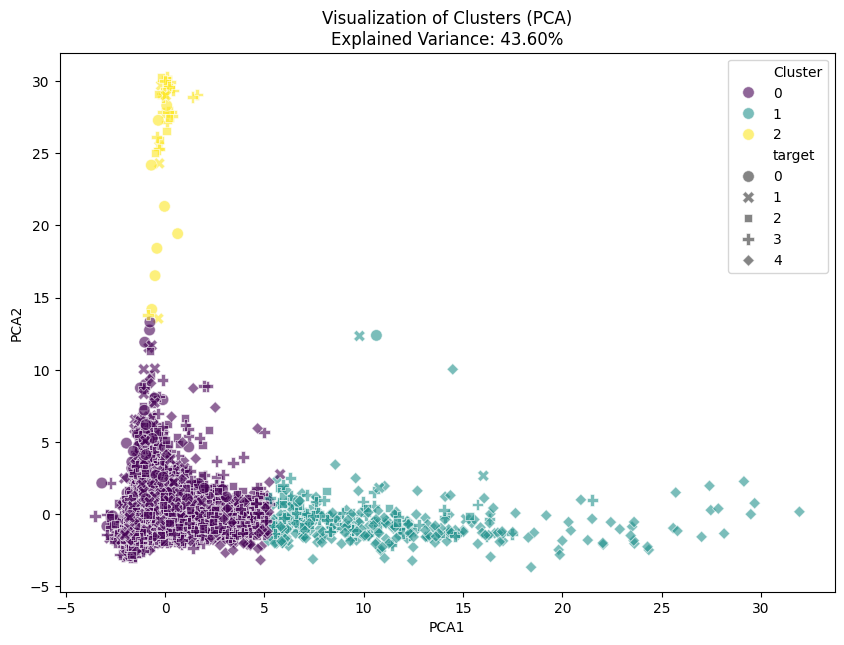

PC1 מסביר: 26.05%
PC2 מסביר: 17.55%


In [22]:
from sklearn.decomposition import PCA
import seaborn as sns

# 1. הרצת K-Means עם K=3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df_ml['Cluster'] = kmeans.fit_predict(X_scaled)

# 2. שימוש ב-PCA לצמצום מימדים לצורך הצגה גרפית
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_ml['PCA1'] = X_pca[:, 0]
df_ml['PCA2'] = X_pca[:, 1]

# 3. יצירת הגרף
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_ml, x='PCA1', y='PCA2', hue='Cluster', palette='viridis',style='target', s=70, alpha=0.6)
plt.title(f'Visualization of Clusters (PCA)\nExplained Variance: {pca.explained_variance_ratio_.sum():.2%}')
plt.show()

print(f"PC1 מסביר: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2 מסביר: {pca.explained_variance_ratio_[1]:.2%}")

###  Cluster Profiling based on Top Features
We connect our Classification model with Clustering by analyzing the averages of the most important features identified during Feature Importance:
* **CPETRSKP** (% Students At-Risk)
* **Social_Vulnerability_Index (SVI)**
* **CPETGIFP** (% Gifted and Talented)
* **CPETASIP** (% Bilingual/ESL)
* **target** (Average Numerical Rating)

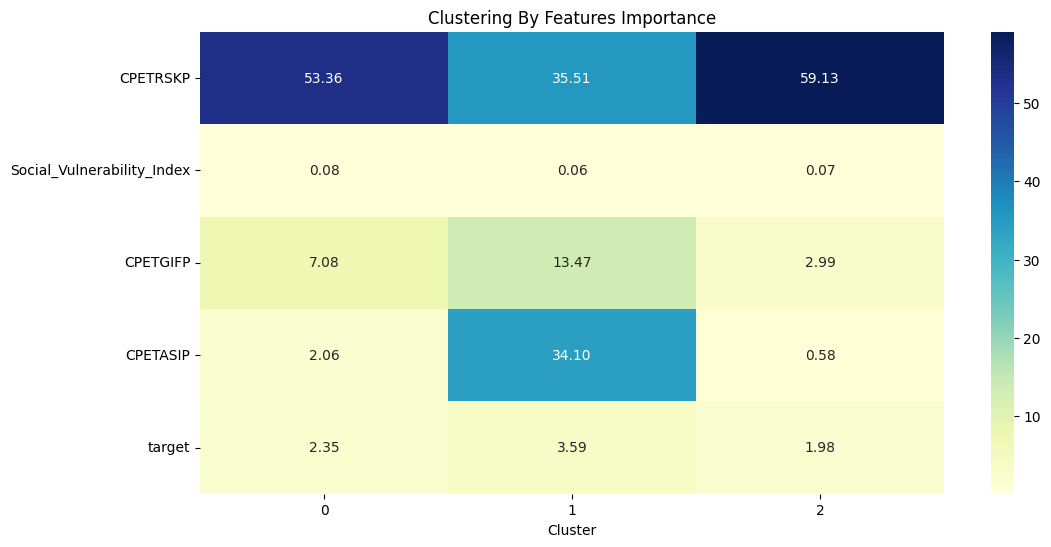

,CPETRSKP,Social_Vulnerability_Index,CPETGIFP,CPETASIP,target
Cluster,,,,,
0,53.361,0.084,7.077,2.058,2.355
1,35.509,0.057,13.475,34.100,3.590
2,59.132,0.066,2.993,0.583,1.976


In [26]:
# 1. הגדרת הפיצ'רים שהמודל סימן כהכי חשובים
top_features = [
    'CPETRSKP',                   # % תלמידים בסיכון
    'Social_Vulnerability_Index', # מדד פגיעות חברתית
    'CPETGIFP',                   # % מחוננים
    'CPETASIP',                   # % דו-לשוניים
    'target'                      # הציון הממוצע (A=4, F=0)
]

# 2. יצירת טבלת ממוצעים ו-Heatmap
cluster_profiles = df_ml.groupby('Cluster')[top_features].mean().round(3)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Clustering By Features Importance')
plt.show()

display(cluster_profiles)

#### Key Insights from the Generated Clusters:

Based on the mean values of our key features, we can define the "identity" of each cluster:

1. **Cluster 1 (The Resource-Rich Achievers):**
   * **Profile:** This is the highest-performing group (**Target: 3.59**).
   * **Key Drivers:** These schools have the highest percentage of **Gifted students (13.5%)** and **Bilingual programs (34.1%)**, combined with the lowest **Social Vulnerability (0.057)**.
   * **Takeaway:** Excellence is strongly correlated with a high concentration of specialized academic programs and a stable socio-economic environment.

2. **Cluster 0 (The Vulnerable Middle-Tier):**
   * **Profile:** This group faces the highest **Social Vulnerability (0.084)** but maintains a respectable "C" average (**Target: 2.35**).
   * **Key Drivers:** Despite being in the most socially challenged areas, they manage to keep **At-Risk** levels moderate (53.3%) compared to Cluster 2.
   * **Takeaway:** These schools show resilience, staying afloat despite high systemic vulnerability.

3. **Cluster 2 (High-Risk & Under-Resourced):**
   * **Profile:** The lowest-performing group (**Target: 1.97**).
   * **Key Drivers:** Defined by the highest **At-Risk population (59.1%)** and nearly zero access to **Gifted (2.9%)** or **Bilingual (0.5%)** programs.
   * **Takeaway:** The lack of specialized support programs combined with high dropout risks directly results in failing grades.

###  Anomaly Detection (Management by Exception)

The true power of this model lies in identifying schools that "defy" their cluster's logic. We focus specifically on **Negative Outliers** in Cluster 1.

* **The Logic:** Schools in Cluster 1 have the best environment (High Gifted %, Low SVI). If such a school receives a **D or F rating**, the problem isn't a lack of resources or a difficult population—it is likely an **operational or leadership failure**.


In [24]:
# 1. מציאת הדירוג הטיפוסי לכל אשכול
cluster_modes = df_ml.groupby('Cluster')['target'].apply(lambda x: x.mode()[0]).reset_index()
cluster_modes.columns = ['Cluster', 'Dominant_Rating']

# 2. איתור בתי ספר עם פער גדול (למשל: באשכול חזק אבל קיבלו ציון נמוך)
df_anomalies = df_ml.merge(cluster_modes, on='Cluster')
df_anomalies['Rating_Gap'] = abs(df_anomalies['target'] - df_anomalies['Dominant_Rating'])

# שליפת 5 החריגים הכי מעניינים (למשל אשכול 1 שקיבלו F)
critical_anomalies = df_anomalies[(df_anomalies['Cluster'] == 1) & (df_anomalies['target'] <= 1)]

print(f"נמצאו {len(df_anomalies[df_anomalies['Rating_Gap'] >= 2])} חריגים משמעותיים.")
display(critical_anomalies[['CAMPUS', 'Overall\nRating', 'CPETRSKP', 'Social_Vulnerability_Index']].head())

נמצאו 1634 חריגים משמעותיים.


,CAMPUS,Overall\nRating,CPETRSKP,Social_Vulnerability_Index
1521,57844001.0,D,66.7,0.120060
1522,57844101.0,D,67.1,0.082533
1591,57903123.0,D,66.7,0.154077
2041,57916135.0,D,83.3,0.192423
2666,79907112.0,D,28.7,0.069454


### Final Project Conclusion: From Data to Actionable Strategy

1. **Classification Success:** Our initial model successfully identified the key features (Gifted %, SVI, At-Risk %) that predict a school's success with high importance scores.
2. **Clustering Revelation:** The unsupervised analysis proved that school performance isn't just about "money"—it's about the **strategic allocation of programs** like Gifted and Bilingual education.
3. **Actionable Insights:** We moved beyond simple rankings (A-F) to create a **"Risk Map."** We can now tell policymakers exactly which schools are underperforming relative to their potential (The Anomalies) and which clusters need structural support (Cluster 2).


In [29]:
#!pip freeze > requirements.txt
